# Predicition modelling of inpatient paediatric risk of Hypoxia: Are imputation and Up-sampling approaches productive?

In [1]:
import os
import ast
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import (RepeatedStratifiedKFold, 
                                     StratifiedKFold)
from sklearn.metrics import confusion_matrix

from xgboost import XGBClassifier

from sklearn.impute import MissingIndicator
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN

from sklearn.metrics import (accuracy_score, brier_score_loss,
                            precision_score, recall_score,
                            f1_score, roc_auc_score)

from sklearn.calibration import CalibratedClassifierCV,calibration_curve


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

from tqdm.auto import tqdm
from tqdm import tnrange,tqdm_notebook

import random
import warnings
warnings.filterwarnings('ignore')

sns.set(rc={'figure.figsize':(9,6),'lines.linewidth': 5, 'lines.markersize': 10})
plt.style.use('seaborn-whitegrid')
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid",{"font.family": ["Corbel"]})

### Read, recode and prepare data

In [2]:
# Read data into workspace 
data = pd.read_csv("Hypoxia.csv")

Age_One_Hot_Encoded = pd.get_dummies(data.Age, prefix="Age_",dummy_na=True)
#Age_One_Hot_Encoded.drop('Age__>= 5 years',axis=1, inplace=True)

AVPU_One_Hot_Encoded = pd.get_dummies(data.AVPU, prefix="AVPU_",dummy_na=True)
#AVPU_One_Hot_Encoded.drop('AVPU__Alert',axis=1, inplace=True)

Pallor_One_Hot_Encoded = pd.get_dummies(data.Pallor, prefix="Pallor_",dummy_na=True)
#Pallor_One_Hot_Encoded.drop('Pallor__None',axis=1, inplace=True)

WAZ_One_Hot_Encoded = pd.get_dummies(data.WAZ_SD, prefix="WAZ_",dummy_na=True)
#WAZ_One_Hot_Encoded.drop('WAZ__Normal',axis=1, inplace=True)

Acute_Malnutrition_One_Hot_Encoded = pd.get_dummies(data.Acute_Malnutrition,
                                                   prefix="Acute_Malnutrition_",
                                                   dummy_na=True)
#Acute_Malnutrition_One_Hot_Encoded.drop('Acute_Malnutrition__None',
#                                        axis=1, inplace=True)

# Dataframe with all the replacement columns
oneHotEncodedColumns = pd.concat([Age_One_Hot_Encoded,
                                 AVPU_One_Hot_Encoded,
                                 Pallor_One_Hot_Encoded,
                                 WAZ_One_Hot_Encoded,
                                 Acute_Malnutrition_One_Hot_Encoded],
                                 axis=1)

# Drop one-hot encoded factor columns
data.drop(["Age","AVPU","Pallor","WAZ_SD","Acute_Malnutrition"],
         axis=1,
         inplace=True)

# Add the newly-coded variables
data = pd.concat([data, oneHotEncodedColumns], axis=1)

# Re-order columns
column_names = data.columns.to_list()
column_names.remove('Low_SpO2')
column_names.append('Low_SpO2')
data = data[column_names]
recoded_col_names = [col_name.replace("<","")\
                     .replace(">=","")\
                     .replace("-","_")\
                     .replace(" ","_")\
                     .replace("/","_") for col_name in column_names]

data.columns = recoded_col_names
data.drop("Very_Low_SpO2",axis=1,inplace=True)
data.head()

,Hospital,Workload,Malaria_Endemicity_Zone,Referral,Readmission,Age_In_Months,Female,Weight,Length_Of_History,Number_Respiratory_Symptoms,...,Pallor__nan,WAZ__Low,WAZ__Normal,WAZ__Very_Low,WAZ__nan,Acute_Malnutrition__Moderate,Acute_Malnutrition__None,Acute_Malnutrition__Severe,Acute_Malnutrition__nan,Low_SpO2
0,H1,High,High,0.0,1.0,24.0,1.0,9.0,2.0,3,...,0,1,0,0,0,1,0,0,0,0
1,H1,High,High,1.0,0.0,39.0,0.0,15.0,2.0,1,...,0,0,1,0,0,0,1,0,0,0
2,H1,High,High,0.0,0.0,108.0,0.0,28.0,2.0,3,...,0,0,0,0,1,0,0,0,1,0
3,H1,High,High,0.0,0.0,108.0,0.0,32.0,2.0,2,...,0,0,0,0,1,0,1,0,0,0
4,H1,High,High,0.0,0.0,2.0,0.0,4.1,4.0,3,...,0,1,0,0,0,0,1,0,0,0


In [3]:
data.columns

Index(['Hospital', 'Workload', 'Malaria_Endemicity_Zone', 'Referral',
       'Readmission', 'Age_In_Months', 'Female', 'Weight', 'Length_Of_History',
       'Number_Respiratory_Symptoms', 'Comorbidities', 'Temparature', 'Fever',
       'Cough', 'Difficulty_Breathing', 'Cyanosis', 'Indrawing', 'Grunting',
       'Acidotic_Breathing', 'Wheezing', 'Crackles', 'Respiratory_Rate',
       'Tachypnea', 'Stridor', 'Pulse_Rate', 'Vomiting', 'Capillary_Refill',
       'Capillary_Refill_Slow', 'Difficulty_Drinking', 'Thrush', 'Oedema',
       'Stiff_Neck', 'Bulging_Fontanelle', 'Diarrhoea_Sign', 'WAZ',
       'Convulsions', 'Age__1_11_months', 'Age__12_59_months', 'Age___1_month',
       'Age___5_years', 'Age__nan', 'AVPU__Alert', 'AVPU__Pain_response',
       'AVPU__Unresponsive', 'AVPU__Verbal_response', 'AVPU__nan',
       'Pallor__Mild_Moderate', 'Pallor__None', 'Pallor__Severe',
       'Pallor__nan', 'WAZ__Low', 'WAZ__Normal', 'WAZ__Very_Low', 'WAZ__nan',
       'Acute_Malnutrition__Moderate

In [4]:
complete_cases_dataset = data.dropna()

In [5]:
sample_frame = data[['Malaria_Endemicity_Zone',
                     'Workload',
                     'Hospital']].drop_duplicates(['Malaria_Endemicity_Zone',
                                                   'Workload',
                                                   'Hospital']).reset_index(drop=True)
sample_frame

,Malaria_Endemicity_Zone,Workload,Hospital
0,High,High,H1
1,High,High,H2
2,Low,Medium,H3
3,High,Low,H4
4,High,High,H5
5,High,High,H6
6,Low,Low,H7
7,Low,Medium,H8
8,Low,High,H9
9,High,Medium,H10


In [6]:
# External validation hospitals 
External_validation_hospitals = sample_frame.groupby('Malaria_Endemicity_Zone', group_keys=False)\
.apply(lambda x: x.sample(min(len(x), 1),random_state = 0))\
.Hospital\
.unique()\
.tolist()

External_validation_hospitals

['H15', 'H8']

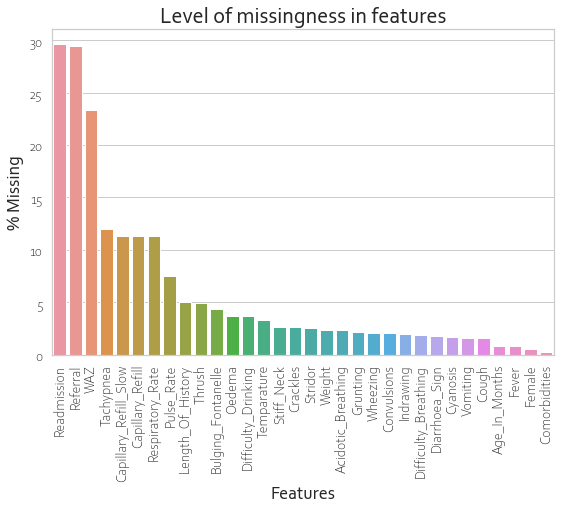

In [7]:
# Exploration of missingness in features
rows = data.shape[0]
feature_missing_counts = data.isnull().sum()
feature_missing_counts = feature_missing_counts.to_frame()
feature_missing_counts.reset_index(inplace=True)
feature_missing_counts.columns = ['Features','Count_Missing']
feature_missing_counts['Percentage_Missing'] = round((feature_missing_counts.Count_Missing / rows)*100,2)
feature_missing_counts = feature_missing_counts[feature_missing_counts.Percentage_Missing > 0.0]
feature_missing_counts = feature_missing_counts.sort_values(['Percentage_Missing'],ascending=False)
chart = sns.barplot(x="Features", y="Percentage_Missing", data=feature_missing_counts)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90,
                  fontweight='light', fontsize='14')
plt.setp(chart.get_yticklabels(), rotation=0,
        fontweight='light', fontsize='14')
chart.axes.set_title("Level of missingness in features",fontsize=22)
chart.set_xlabel("Features",fontsize=18)
chart.set_ylabel("% Missing",fontsize=18)

plt.show()

In [8]:
rows_complete_data = data.dropna().shape[0]
print("Of the {} observations with pulse oximetry measure, {} ({:.2f}%) are complete (i.e. no missingness)"\
      .format(rows, rows_complete_data, (rows_complete_data/rows)*100))
print("\nSample size required, N = n / (1- %records with missing data)\n")

print("n is given by the formula below:")

Of the 57180 observations with pulse oximetry measure, 19138 (33.47%) are complete (i.e. no missingness)

Sample size required, N = n / (1- %records with missing data)

n is given by the formula below:


$
\begin{align}
n & = \biggl(\frac{1.96}{0.05}\biggl)^{2}  *  \hat{\phi}(1-\hat{\phi})\\
\end{align}
$

https://www.bmj.com/content/368/bmj.m441.long?s=09

https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(09)70071-4/fulltext 

In [9]:
n = int(np.ceil(np.power(np.divide(1.96,0.05),2) * (0.23 * (1-0.23))))

print("\nSample size required: {:.0f}".format(np.ceil(n /(rows_complete_data/rows))))


Sample size required: 816


In [10]:
data["High_Malaria_Zone"] = 0
data.loc[data.Malaria_Endemicity_Zone=="High",["High_Malaria_Zone"]] = 1

test_dataset = data[data.Hospital.isin(External_validation_hospitals)].copy()
test_dataset.drop(["Hospital","Workload","Malaria_Endemicity_Zone"],
                  axis=1,
                  inplace=True)

features = test_dataset.columns.tolist()
features.remove("Low_SpO2")

testX = test_dataset[features]

scaler = StandardScaler()
testX.loc[:,'Age_In_Months'] = scaler.fit_transform(np.array(testX['Age_In_Months'].copy())\
                                                    .reshape(-1,1))
testX.loc[:,'Weight'] = scaler.fit_transform(np.array(testX['Weight'].copy()).reshape(-1,1))
testX.loc[:,'Temparature'] = scaler.fit_transform(np.array(testX['Temparature'].copy())\
                                                  .reshape(-1,1))
testX.loc[:,'Pulse_Rate'] = scaler.fit_transform(np.array(testX['Pulse_Rate'].copy())\
                                                 .reshape(-1,1))
testX.loc[:,'Respiratory_Rate'] = scaler.fit_transform(np.array(testX['Respiratory_Rate'].copy())\
                                                       .reshape(-1,1))
test_y = test_dataset["Low_SpO2"].values

test_dataset.shape

(3007, 57)

In [11]:
# Train and internal validation hospitals
train_dataset = data[~data.Hospital.isin(External_validation_hospitals)].copy()
train_dataset.drop(["Hospital","Workload","Malaria_Endemicity_Zone"],
                  axis=1,
                  inplace=True)

trainX = train_dataset[features]
trainX.loc[:,'Age_In_Months'] = scaler.fit_transform(np.array(trainX['Age_In_Months'].copy())\
                                                    .reshape(-1,1))
trainX.loc[:,'Weight'] = scaler.fit_transform(np.array(trainX['Weight'].copy()).reshape(-1,1))
trainX.loc[:,'Temparature'] = scaler.fit_transform(np.array(trainX['Temparature'].copy())\
                                                  .reshape(-1,1))
trainX.loc[:,'Pulse_Rate'] = scaler.fit_transform(np.array(trainX['Pulse_Rate'].copy())\
                                                 .reshape(-1,1))
trainX.loc[:,'Respiratory_Rate'] = scaler.fit_transform(np.array(trainX['Respiratory_Rate'].copy())\
                                                       .reshape(-1,1))
train_y = train_dataset["Low_SpO2"].values

train_dataset.shape

(54173, 57)

#### Variable correlation

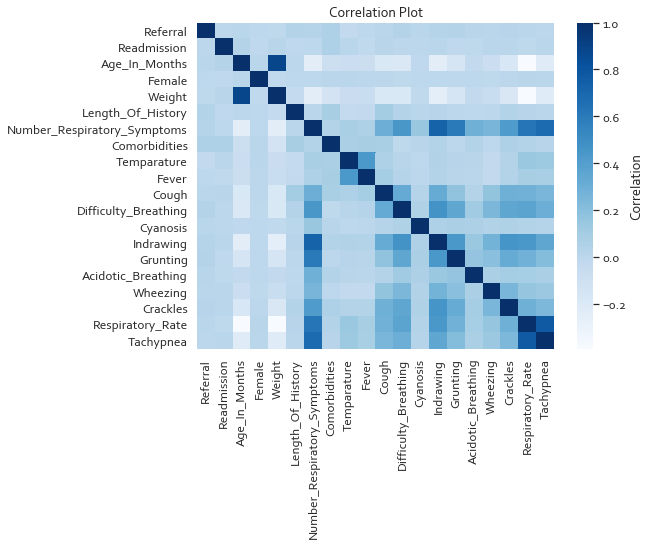

In [12]:
# Correlation plot
f, ax = plt.subplots(figsize=[8,6])
sns.heatmap(data.iloc[:,:23].corr(),
            annot=False, fmt=".2f",cbar_kws={'label': 'Correlation'},cmap="Blues",ax=ax)
ax.set_title("Correlation Plot")
plt.show()

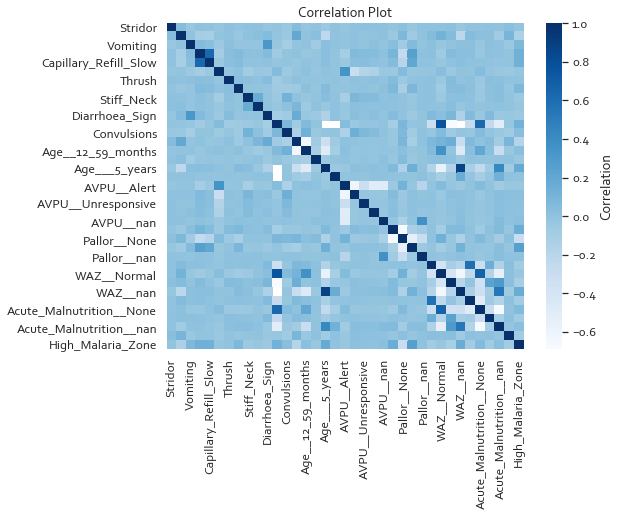

In [13]:
f, ax = plt.subplots(figsize=[8,6])
sns.heatmap(data.iloc[:,23:].corr(),
            annot=False, fmt=".2f",cbar_kws={'label': 'Correlation'},cmap="Blues",ax=ax)
ax.set_title("Correlation Plot")
plt.show()

In [14]:
print("Depedent Variable Distribution")
print(data.Low_SpO2.value_counts(normalize=True)*100)
print("0 = Normal", "\n1 = Hypoxic")

Depedent Variable Distribution
0    92.380203
1     7.619797
Name: Low_SpO2, dtype: float64
0 = Normal 
1 = Hypoxic


In [15]:
# Calculating level of imbalance for future models.
imbalance_weight = data.Low_SpO2.value_counts(normalize=True)[0]/data.Low_SpO2.value_counts(normalize=True)[1]
print("Imbalance Weight: ",imbalance_weight)

Imbalance Weight:  12.123708974064723


#### Dealing with imbalance in the outcome

In [16]:
# Dealing with imbalance: Empric approach to sampling selection
# These parameters can be tuned

oversample_smote = SMOTE(sampling_strategy='auto', 
                         k_neighbors=10,
                         random_state=0
                        )

oversample_borderline_smote = BorderlineSMOTE(sampling_strategy='auto', 
                                              k_neighbors=10, 
                                              m_neighbors=10,
                                              random_state=0)

oversample_svmsmote = SVMSMOTE(sampling_strategy='auto', 
                               k_neighbors=10, 
                               m_neighbors=10,
                               random_state=0)

oversample_adasyn = ADASYN(sampling_strategy='auto', 
                           n_neighbors=10,
                           random_state=0)

oversample_dict = {
    'smote':oversample_smote,
    'borderline_smote':oversample_borderline_smote,
    'svmsmote': oversample_svmsmote,
    'adasyn': oversample_adasyn
}

### ML approaches for prognostic modelling

In [16]:
# Using an ensemble voting modelling approach
# XGBClassifier param_grid = [{'min_child_weight': np.arange(0.1, 10.1, 0.1)}] 
#    set of trial values for min_child_weight

models = [{'name': 'logreg','label': 'Logistic Regression',
           'classifier': LogisticRegression(random_state=0),
           'grid': {"logreg__C":np.logspace(-6,-3,4), "logreg__penalty":["l1","l2"]}},
          
          {'name': 'knn','label':'K Nearest Neighbors',
           'classifier':KNeighborsClassifier(),
           'grid': {"knn__n_neighbors":[1, 4, 8, 16, 32]}},
          
          {'name': 'dsc','label': 'Descision Tree', 
           'classifier': DecisionTreeClassifier(random_state=0),
           'grid': {"dsc__max_depth":[5,6,7,8]}},
          
          {'name': 'rf', 'label': 'Random Forest',
           'classifier': RandomForestClassifier(random_state=0),
           'grid': {'rf__n_estimators': [500],'rf__max_features': ['auto', 'log2'],
                    'rf__max_depth' : [5,6,7,8],'rf__criterion' :['gini']}},
          
          {'name': 'svm_rbf', 'label': 'SVC (RBF)',
           'classifier':SVC(random_state=0,probability=True),
           'grid': {'svm_rbf__C': [1, 10], 'svm_rbf__gamma': [0.001, 0.0001], 
                    'svm_rbf__kernel': ['rbf']}},
          
          {'name': 'xgb', 'label': 'XGB Classifier',
           'classifier':XGBClassifier(),
           'grid': {'xgb__n_estimators': [500], 'xgb__learning_rate': [0.01, 0.05], 
                    'xgb__max_depth': [5,6,7,8], 'xgb__early_stopping_rounds':[10]}}
         
         ]

https://scikit-learn.org/stable/modules/model_evaluation.html

https://stackoverflow.com/questions/46793110/using-votingclassifier-in-sklearn-pipeline

#### Machine Learning pipeline (Using imputation and up-sampling)

In [17]:
def generate_model_params_perf(sampling_method='smote'):
    model_results = {}
    model_params = {}
    imputer = IterativeImputer(max_iter=15, random_state=0)
    for model in models:
        pipeline = Pipeline([
                ('imputation', imputer), # Step 1: Deal with missing data
                ('sampling', oversample_dict[sampling_method]), # Step 2: Upsample the minority class
                (model['name'], model['classifier']) # Step 3: Fit model
        ])
        
        rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
        
        cv_grid = GridSearchCV(
            pipeline, #Machine learning pipeline
            param_grid = model['grid'],
            verbose = 10,
            cv = skf, #internal repeated cross-validation
            scoring= 'neg_brier_score', #Balanced discrimination/calibration
            n_jobs=7, #Parallelised computing
        )
        
        model_fit = cv_grid.fit(trainX, train_y)
        
        score = pd.DataFrame.from_dict({
            "Model":[model['name']],
            "Sampling":[sampling_method],
            "Best_Params":[model_fit.best_params_],
            "Brier_Score": [model_fit.best_score_]
        })
        
        score.to_csv('model_results.csv', mode='a', header=False, index=False)



if os.path.isfile("model_results.csv"):
    model_init_params = pd.read_csv("model_results.csv")
    
if model_init_params.shape[0] == 0:
    for sampling_method in tqdm(oversample_dict):
        generate_model_params_perf(sampling_method)
    model_init_params = pd.read_csv("model_results.csv")
else:
    print("\nModel results loaded\n")    


Model results loaded



In [18]:
idx = model_init_params.groupby(['Model','Sampling'])['Brier_Score']\
.transform(max) == model_init_params['Brier_Score']
model_final_params = model_init_params[idx]
model_final_params.Brier_Score = -model_final_params.Brier_Score
model_final_params['Approach'] = 'MI + Up-sampling'
model_final_params.head()

,Model,Sampling,Best_Params,Brier_Score,Approach
0,logreg,smote,"{'logreg__C': 0.001, 'logreg__penalty': 'l2'}",0.181406,MI + Up-sampling
1,knn,smote,{'knn__n_neighbors': 4},0.207607,MI + Up-sampling
2,dsc,smote,{'dsc__max_depth': 8},0.112415,MI + Up-sampling
3,rf,smote,"{'rf__criterion': 'gini', 'rf__max_depth': 8, ...",0.116339,MI + Up-sampling
4,svm_rbf,smote,"{'svm_rbf__C': 10, 'svm_rbf__gamma': 0.001, 's...",0.174753,MI + Up-sampling


In [19]:
model_final_params.shape

(24, 5)

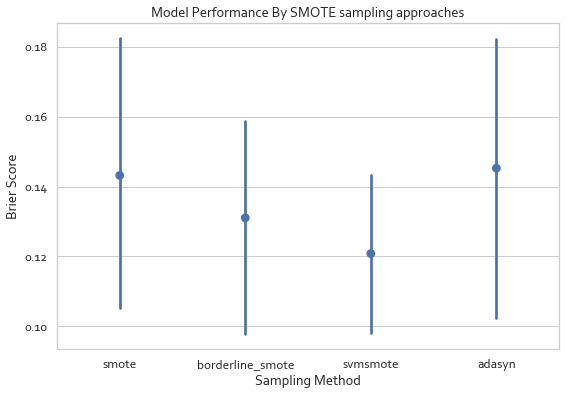

In [20]:
ax = sns.pointplot(x="Sampling", 
                   y="Brier_Score", 
                   data=model_final_params, join=False)

ax.set(xlabel='Sampling Method', 
       ylabel='Brier Score', 
       title='Model Performance By SMOTE sampling approaches')
plt.show()

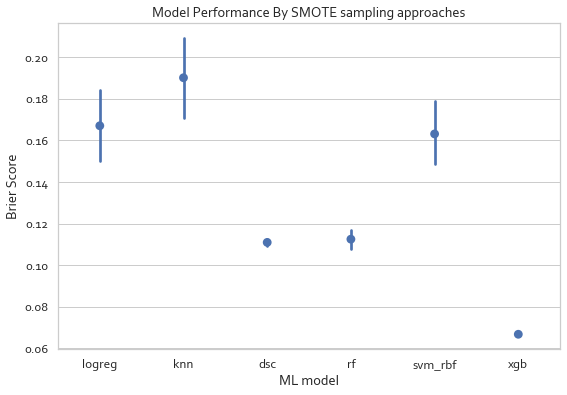

In [21]:
ax = sns.pointplot(x="Model", y="Brier_Score", data=model_final_params, join=False)
ax.set(xlabel='ML model', ylabel='Brier Score', 
       title='Model Performance By SMOTE sampling approaches')
plt.show()

In [22]:
idx = model_init_params.groupby(['Model'])['Brier_Score']\
.transform(max) == model_init_params['Brier_Score']
model_test_params = model_init_params[idx]

In [23]:
if os.path.isfile("final_model.pickle"):
    with open("final_model.pickle","rb") as f:
        cv_models = pickle.load(f)
else:
    cv_models = {}    

    for index,row in model_test_params.iterrows():
        classifier = [model['classifier'] for model in models\
                      if model['name']==row['Model']][0]

        params = ast.literal_eval(row['Best_Params'])
        model_params = {key:[value] for key, value in params.items()}
        pipeline = Pipeline([
            ('imputation', imputer), # Step 1: Deal with missing data
            ('sampling', oversample_dict[row['Sampling']]), # Step 2: Upsample the minority class
            (row['Model'], classifier) # Step 3: Fit model
        ])

        rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=0)

        cv_grid_final = GridSearchCV(
            pipeline, #Machine learning pipeline
            param_grid = model_params,
            verbose = 10,
            cv = rskf, #internal repeated cross-validation
            scoring= 'neg_brier_score', #Balanced discrimination/calibration
            n_jobs=7 #Parallelised computing
        )

        cv_models[row['Model']] = cv_grid_final.fit(trainX, train_y)
        
    with open('final_model.pickle',"wb") as f:
        pickle.dump(cv_models, f, pickle.HIGHEST_PROTOCOL)

### External validation of model predictive performance
#### Uses different set of hospitals not included in data for model training.

logreg:
	Brier: 0.157
	Precision: 0.215
	Recall: 0.632
	F1: 0.321

knn:
	Brier: 0.186
	Precision: 0.200
	Recall: 0.441
	F1: 0.275

dsc:
	Brier: 0.119
	Precision: 0.238
	Recall: 0.232
	F1: 0.235

rf:
	Brier: 0.122
	Precision: 0.244
	Recall: 0.507
	F1: 0.330

svm_rbf:
	Brier: 0.167
	Precision: 0.210
	Recall: 0.673
	F1: 0.320

xgb:
	Brier: 0.080
	Precision: 0.242
	Recall: 0.059
	F1: 0.095



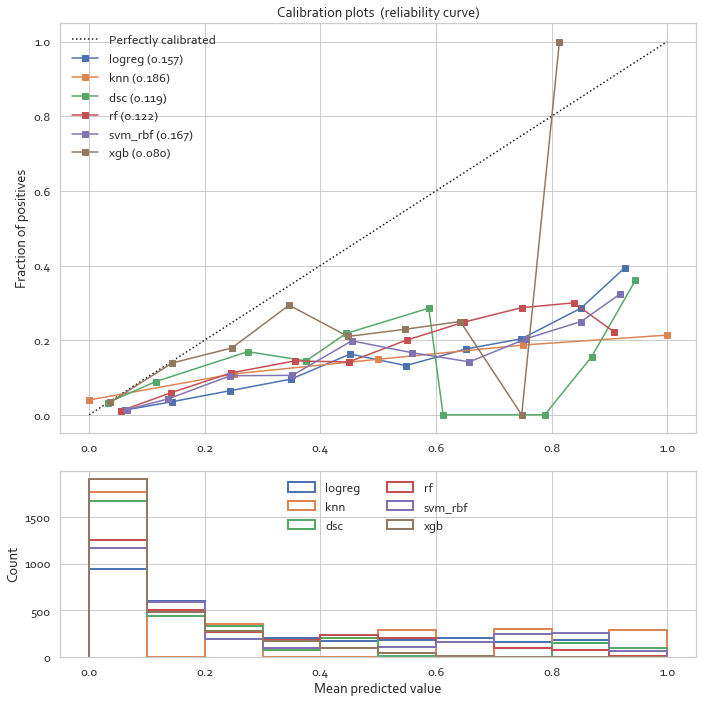

In [24]:
fig = plt.figure(2, figsize=(10, 10))
model_test_params.reset_index(drop=True,inplace=True)

ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for index,row in model_test_params.iterrows():
    
    y_pred = cv_models[row['Model']].predict(testX)
    prob_pos = cv_models[row['Model']].predict_proba(testX)[:,1]
    clf_score = brier_score_loss(test_y, prob_pos, pos_label=1)
    
    print("%s:" % row['Model'])
    print("\tBrier: %1.3f" % (clf_score))
    print("\tPrecision: %1.3f" % precision_score(test_y, y_pred))
    print("\tRecall: %1.3f" % recall_score(test_y, y_pred))
    print("\tF1: %1.3f\n" % f1_score(test_y, y_pred))

    fraction_of_positives, mean_predicted_value = \
        calibration_curve(test_y, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s (%1.3f)" % (row['Model'], clf_score))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=row['Model'],
             histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="upper left")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

plt.show()

## Complete case analysis

In [17]:
complete_cases_dataset["High_Malaria_Zone"] = 0
complete_cases_dataset.loc[\
                           complete_cases_dataset\
                           .Malaria_Endemicity_Zone=="High",["High_Malaria_Zone"]] = 1

test_dataset_complete_case = complete_cases_dataset[complete_cases_dataset.Hospital\
                    .isin(External_validation_hospitals)].copy()
test_dataset_complete_case.drop(["Hospital","Workload","Malaria_Endemicity_Zone"],
                  axis=1,
                  inplace=True)

features = test_dataset_complete_case.columns.tolist()
features.remove("Low_SpO2")

testX_complete_case = test_dataset_complete_case[features]

testX_complete_case.loc[:,'Age_In_Months'] = scaler\
.fit_transform(np.array(testX_complete_case['Age_In_Months'].copy())\
                                                    .reshape(-1,1))
testX_complete_case.loc[:,'Weight'] = scaler\
.fit_transform(np.array(testX_complete_case['Weight'].copy()).reshape(-1,1))
testX_complete_case.loc[:,'Temparature'] = scaler\
.fit_transform(np.array(testX_complete_case['Temparature'].copy())\
                                                  .reshape(-1,1))
testX_complete_case.loc[:,'Pulse_Rate'] = scaler\
.fit_transform(np.array(testX_complete_case['Pulse_Rate'].copy())\
                                                 .reshape(-1,1))
testX_complete_case.loc[:,'Respiratory_Rate'] = scaler\
.fit_transform(np.array(testX_complete_case['Respiratory_Rate'].copy())\
                                                       .reshape(-1,1))
test_y_complete_case = test_dataset_complete_case["Low_SpO2"].values

test_dataset_complete_case.shape

(1135, 57)

In [18]:
# Train and internal validation hospitals
train_dataset_complete_case = complete_cases_dataset[~complete_cases_dataset\
                     .Hospital.isin(External_validation_hospitals)].copy()
train_dataset_complete_case.drop(["Hospital","Workload","Malaria_Endemicity_Zone"],
                  axis=1,
                  inplace=True)

trainX_complete_case = train_dataset_complete_case[features]
trainX_complete_case.loc[:,'Age_In_Months'] = scaler\
.fit_transform(np.array(trainX_complete_case['Age_In_Months'].copy())\
                                                    .reshape(-1,1))
trainX_complete_case.loc[:,'Weight'] = scaler\
.fit_transform(np.array(trainX_complete_case['Weight'].copy()).reshape(-1,1))
trainX_complete_case.loc[:,'Temparature'] = scaler\
.fit_transform(np.array(trainX_complete_case['Temparature'].copy())\
                                                  .reshape(-1,1))
trainX_complete_case.loc[:,'Pulse_Rate'] = scaler\
.fit_transform(np.array(trainX_complete_case['Pulse_Rate'].copy())\
                                                 .reshape(-1,1))
trainX_complete_case.loc[:,'Respiratory_Rate'] = scaler\
.fit_transform(np.array(trainX_complete_case['Respiratory_Rate'].copy())\
                                                       .reshape(-1,1))
train_y_complete_case = train_dataset_complete_case["Low_SpO2"].values

train_dataset_complete_case.shape

(18003, 57)

In [27]:
def generate_model_params_perf_complete_cases(sampling_method='smote'):
    model_results = {}
    model_params = {}
    for model in models:
        pipeline = Pipeline([
                ('sampling', oversample_dict[sampling_method]), # Step 2: Upsample the minority class
                (model['name'], model['classifier']) # Step 3: Fit model
        ])
        
        rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
        
        cv_grid = GridSearchCV(
            pipeline, #Machine learning pipeline
            param_grid = model['grid'],
            verbose = 10,
            cv = skf, #internal repeated cross-validation
            scoring= 'neg_brier_score', #Balanced discrimination/calibration
            n_jobs=7, #Parallelised computing
        )
        
        model_fit = cv_grid.fit(trainX_complete_case,
                                train_y_complete_case)        
              
        score = pd.DataFrame.from_dict({
            "Model":[model['name']],
            "Sampling":[sampling_method],
            "Best_Params":[model_fit.best_params_],
            "Brier_Score": [model_fit.best_score_]
        })
        
        score.to_csv('model_results_complete_cases.csv', mode='a', header=False, index=False)
        
if os.path.isfile("model_results_complete_cases.csv"):
    model_init_params_complete_cases = pd.read_csv("model_results_complete_cases.csv")
    
if model_init_params_complete_cases.shape[0] == 0:
    for sampling_method in tqdm(oversample_dict):
        generate_model_params_perf_complete_cases(sampling_method)
    model_init_params_complete_cases = pd.read_csv("model_results_complete_cases.csv")
else:
    print("\nModel results loaded\n")    


Model results loaded



In [28]:
model_init_params_complete_cases['Approach'] = 'Up-sampling'
model_init_params_complete_cases.head()

,Model,Sampling,Best_Params,Brier_Score,Approach
0,logreg,smote,"{'logreg__C': 0.001, 'logreg__penalty': 'l2'}",-0.178723,Up-sampling
1,knn,smote,{'knn__n_neighbors': 4},-0.232683,Up-sampling
2,dsc,smote,{'dsc__max_depth': 8},-0.114114,Up-sampling
3,rf,smote,"{'rf__criterion': 'gini', 'rf__max_depth': 8, ...",-0.118063,Up-sampling
4,svm_rbf,smote,"{'svm_rbf__C': 10, 'svm_rbf__gamma': 0.001, 's...",-0.155927,Up-sampling


In [29]:
idx = model_init_params_complete_cases.groupby(['Model'])['Brier_Score']\
.transform(max) == model_init_params_complete_cases['Brier_Score']
model_test_params_complete_case = model_init_params_complete_cases[idx]
model_test_params_complete_case

if os.path.isfile("final_model_complete_case.pickle"):
    with open("final_model_complete_case.pickle","rb") as f:
        cv_models = pickle.load(f)
else:
    cv_models = {}    

    for index,row in model_test_params_complete_case.iterrows():
        classifier = [model['classifier'] for model in models\
                      if model['name']==row['Model']][0]

        params = ast.literal_eval(row['Best_Params'])
        model_params = {key:[value] for key, value in params.items()}
        pipeline = Pipeline([
            ('sampling', oversample_dict[row['Sampling']]), # Step 2: Upsample the minority class
            (row['Model'], classifier) # Step 3: Fit model
        ])

        rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=0)

        cv_grid_final = GridSearchCV(
            pipeline, #Machine learning pipeline
            param_grid = model_params,
            verbose = 10,
            cv = rskf, #internal repeated cross-validation
            scoring= 'neg_brier_score', #Balanced discrimination/calibration
            n_jobs=7 #Parallelised computing
        )

        cv_models[row['Model']] = cv_grid_final.fit(trainX_complete_case,
                                                    train_y_complete_case)
        
    with open('final_model_complete_case.pickle',"wb") as f:
        pickle.dump(cv_models, f, pickle.HIGHEST_PROTOCOL)

xgb:
	Brier: 0.067
	Precision: 0.441
	Recall: 0.161
	F1: 0.236

logreg:
	Brier: 0.138
	Precision: 0.221
	Recall: 0.645
	F1: 0.330

knn:
	Brier: 0.165
	Precision: 0.210
	Recall: 0.441
	F1: 0.285

rf:
	Brier: 0.100
	Precision: 0.231
	Recall: 0.387
	F1: 0.289

svm_rbf:
	Brier: 0.126
	Precision: 0.200
	Recall: 0.495
	F1: 0.285

dsc:
	Brier: 0.091
	Precision: 0.221
	Recall: 0.366
	F1: 0.275



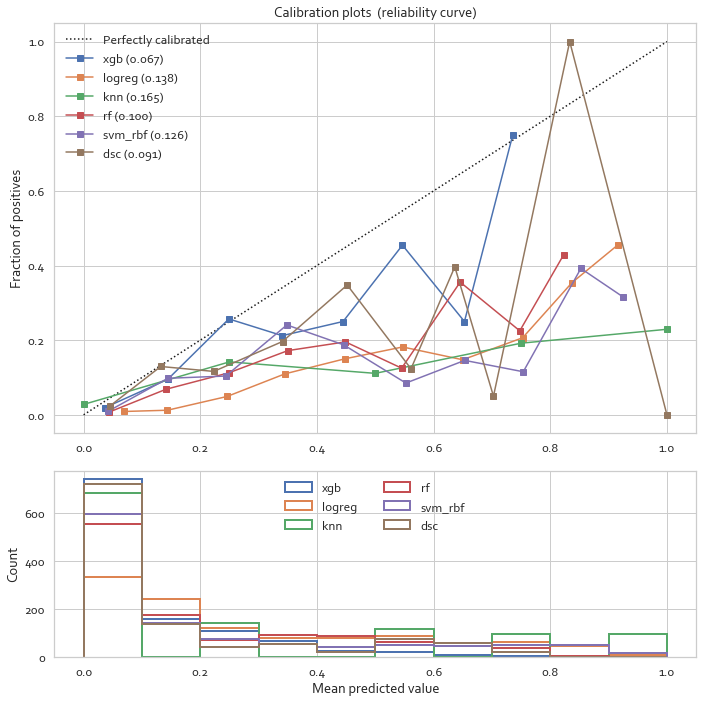

In [30]:
fig = plt.figure(2, figsize=(10, 10))
model_test_params_complete_case.reset_index(drop=True,inplace=True)

ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for index,row in model_test_params_complete_case.iterrows():
    
    y_pred = cv_models[row['Model']].predict(testX_complete_case)
    prob_pos = cv_models[row['Model']].predict_proba(testX_complete_case)[:,1]
    clf_score = brier_score_loss(test_y_complete_case, prob_pos, pos_label=1)
    
    print("%s:" % row['Model'])
    print("\tBrier: %1.3f" % (clf_score))
    print("\tPrecision: %1.3f" % precision_score(test_y_complete_case, y_pred))
    print("\tRecall: %1.3f" % recall_score(test_y_complete_case, y_pred))
    print("\tF1: %1.3f\n" % f1_score(test_y_complete_case, y_pred))

    fraction_of_positives, mean_predicted_value = \
        calibration_curve(test_y_complete_case, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s (%1.3f)" % (row['Model'], clf_score))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=row['Model'],
             histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="upper left")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

plt.show()

In [31]:
cv_models = {}   

def generate_model_params_complete_cases_nosamp():
    model_results = {}
    model_params = {}
    for model in models:
        pipeline = Pipeline([
                (model['name'], model['classifier']) # Step 3: Fit model
        ])
        
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
        
        cv_grid = GridSearchCV(
            pipeline, #Machine learning pipeline
            param_grid = model['grid'],
            verbose = 10,
            cv = skf, #internal repeated cross-validation
            scoring= 'neg_brier_score', #Balanced discrimination/calibration
            n_jobs=7, #Parallelised computing
        )
        
        model_fit = cv_grid.fit(trainX_complete_case,
                                train_y_complete_case)    
        cv_models[model['name']] = model_fit
              
        score = pd.DataFrame.from_dict({
            "Model":[model['name']],
            "Sampling":["None"],
            "Best_Params":[model_fit.best_params_],
            "Brier_Score": [model_fit.best_score_]
        })
        
        score.to_csv('model_results_complete_cases_nosamp.csv', mode='a', header=False, index=False)
        
if os.path.isfile("model_results_complete_cases.csv"):
    model_results_complete_cases_nosamp = pd.read_csv("model_results_complete_cases_nosamp.csv")
    
if model_results_complete_cases_nosamp.shape[0] == 0:
    generate_model_params_complete_cases_nosamp()
    model_results_complete_cases_nosamp = pd.read_csv("model_results_complete_cases_nosamp.csv")
    
    with open('final_model_complete_case_nosamp.pickle',"wb") as f:
        pickle.dump(cv_models, f, pickle.HIGHEST_PROTOCOL)
else:
    
    if os.path.isfile("final_model_complete_case_nosamp.pickle"):
        with open("final_model_complete_case_nosamp.pickle","rb") as f:
            cv_models = pickle.load(f)
    print("\nModel results loaded\n")    


Model results loaded



logreg:
	Brier: 0.067
	Precision: 0.000
	Recall: 0.000
	F1: 0.000

knn:
	Brier: 0.069
	Precision: 0.000
	Recall: 0.000
	F1: 0.000

dsc:
	Brier: 0.068
	Precision: 0.000
	Recall: 0.000
	F1: 0.000

rf:
	Brier: 0.066
	Precision: 0.000
	Recall: 0.000
	F1: 0.000

svm_rbf:
	Brier: 0.075
	Precision: 0.000
	Recall: 0.000
	F1: 0.000

xgb:
	Brier: 0.066
	Precision: 1.000
	Recall: 0.032
	F1: 0.062



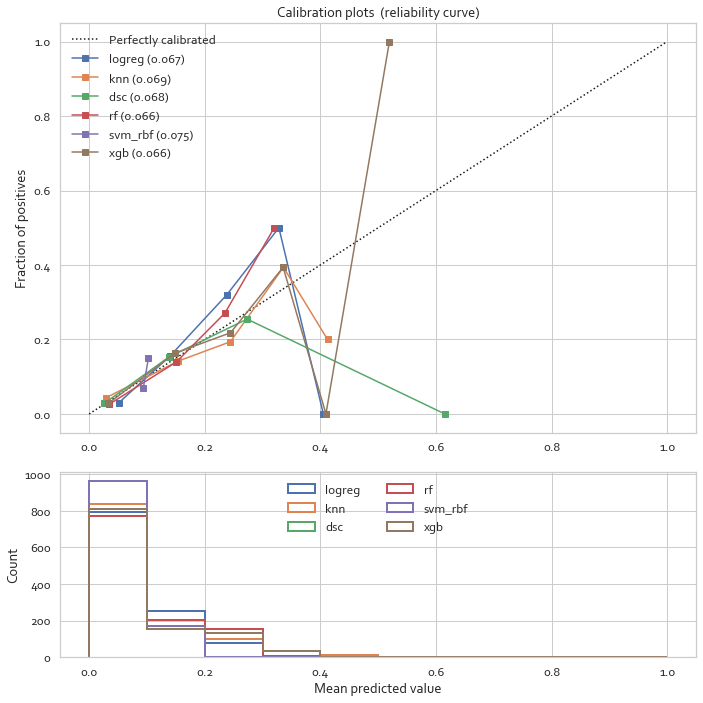

In [32]:
fig = plt.figure(2, figsize=(10, 10))
model_results_complete_cases_nosamp.reset_index(drop=True,inplace=True)

ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for index,row in model_results_complete_cases_nosamp.iterrows():
    
    y_pred = cv_models[row['Model']].predict(testX_complete_case)
    prob_pos = cv_models[row['Model']].predict_proba(testX_complete_case)[:,1]
    clf_score = brier_score_loss(test_y_complete_case, prob_pos, pos_label=1)
    
    print("%s:" % row['Model'])
    print("\tBrier: %1.3f" % (clf_score))
    print("\tPrecision: %1.3f" % precision_score(test_y_complete_case, y_pred))
    print("\tRecall: %1.3f" % recall_score(test_y_complete_case, y_pred))
    print("\tF1: %1.3f\n" % f1_score(test_y_complete_case, y_pred))

    fraction_of_positives, mean_predicted_value = \
        calibration_curve(test_y_complete_case, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s (%1.3f)" % (row['Model'], clf_score))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=row['Model'],
             histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="upper left")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

plt.show()

In [19]:
weights = np.linspace(0.05, 0.95, 5)

models_calibrated = [{'name': 'logreg','label': 'Logistic Regression (SGD)',
                      'classifier': SGDClassifier(random_state=0, n_jobs=7),
                      'grid': {"logreg__loss":['log'], 
                               "logreg__penalty":["l1"],
                               "logreg__class_weight": [{0: x, 1: 1.0-x} for x in weights]}                     
                      },
                     {'name': 'rf', 'label': 'Random Forest',
                      'classifier': RandomForestClassifier(random_state=0, n_jobs=7),
                      'grid': {"rf__n_estimators":[500],
                               "rf__criterion":["entropy"],
                               "rf__min_samples_leaf":[30],
                               "rf__class_weight": [{0: x, 1: 1.0-x} for x in weights]},
                      },
                     {'name': 'svm_linear', 'label': 'SVC (Linear)',
                      'classifier':SGDClassifier(random_state=0, n_jobs=7),
                      'grid': {"svm_linear__loss":['hinge'],
                               "svm_linear__penalty":["l1"],
                               "svm_linear__class_weight": [{0: x, 1: 1.0-x} for x in weights]},
                     },
                     {'name': 'xgb', 'label': 'XGB Classifier',
                      'classifier':XGBClassifier(random_state=0, nthread=7),
                      'grid': {"xgb__n_estimators":[500],
                               "xgb__learning_rate":[0.05],
                               "xgb__min_child_weight":[15]}
                     }]

In [23]:
def generate_model_params(sampling_method='smote',
                          upsampling = False,
                          impute = False,
                         file_name = "model_complete_nosamp"):
    
    cv_models = {} #Store final models for external validation
    
    Approach = ""
    if upsampling and impute:
        Approach = "Upsampling & Imputation"
    if upsampling and not impute:
        Approach = "Upsampling Only"
    if not upsampling and impute:
        Approach = "Imputation Only"
    if not (upsampling or impute):
        Approach = "None"
        
    imputer = IterativeImputer(max_iter=15, random_state=0)
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)
    
    for i in tnrange(len(models_calibrated),desc="Fitting models"):
        model = models_calibrated[i]
        
        features = trainX
        labels = train_y
        
        if not (upsampling and impute):

            features = trainX_complete_case
            labels = train_y_complete_case

            pipeline = Pipeline([
                (model['name'], model['classifier'])# Step 1: Fit model                     
            ])

        if impute and not upsampling:
            if model['name'] == 'xgb':
                pipeline = Pipeline([
                    (model['name'], model['classifier'])                   
                ])
            else:
                pipeline = Pipeline([
                    ('imputation', imputer), # Step 1: Perform imputation (MAR assumption)  
                    (model['name'], model['classifier'])                   
                ])

        if upsampling and not impute:

            features = trainX_complete_case
            labels = train_y_complete_case

            pipeline = Pipeline([
                ('sampling', oversample_dict[sampling_method]), # Step 1: Upsample the minority class
                (model['name'], model['classifier'])                     
            ])

        if upsampling and impute:
            if model['name'] == 'xgb':
                pipeline = Pipeline([
                    ('sampling', oversample_dict[sampling_method]), # Step 2: Upsample the minority class
                    (model['name'], model['classifier'])# Step 3: Fit model                     
                ])
            else:
                pipeline = Pipeline([
                    ('imputation', imputer), # Step 1: Impute missing values
                    ('sampling', oversample_dict[sampling_method]), # Step 2: Upsample the minority class
                    (model['name'], model['classifier'])# Step 3: Fit model                     
                ])
        
        grid = GridSearchCV(estimator=pipeline,
                            param_grid = model['grid'],
                            verbose = False,
                            scoring='roc_auc',
                            cv=skf,
                            n_jobs=7)
        model_fit = grid.fit(features, labels)
        
        if model['name'] == 'xgb':
            model_fit = grid.fit(features.values, labels)
        else:
            model_fit = grid.fit(features, labels)
            
        score = pd.DataFrame.from_dict({
            "Model":[model['label']],
            "Sampling":["None" if not upsampling else sampling_method],
            "Score": [model_fit.best_score_],
            "Approach": [Approach]

        })
        
        score.to_csv(file_name+".csv", mode='a', header=False, index=False)
        
        
        calibrated_pipe = CalibratedClassifierCV(model_fit.best_estimator_)
    
        param_grid = dict(cv=[10], method=['isotonic'])
        grid = GridSearchCV(estimator=calibrated_pipe, 
                            param_grid=param_grid, 
                            n_jobs=7, 
                            cv=rskf, 
                            scoring='roc_auc')

        if model['name'] == 'xgb':
            cv_models[model['label']] = grid.fit(features.values, labels)
        else:
            cv_models[model['label']] = grid.fit(features,labels)
            
    with open(file_name+'.pickle',"wb") as f:
        pickle.dump(cv_models, f, pickle.HIGHEST_PROTOCOL)

In [25]:
#Run model with no upsampling or imputation
if not os.path.isfile("model_complete_nosamp.pickle"):
    generate_model_params(sampling_method='smote',
                          upsampling = False,
                          impute = False,
                          file_name = "model_complete_nosamp") 
    
#Run model with no imputation 
if not os.path.isfile("model_complete_samp.pickle"):
    for i in tnrange(len(oversample_dict),desc="Up-sampling progress"):
        sampling_method = list(oversample_dict.keys())[i]        
        generate_model_params(sampling_method=sampling_method,
                              upsampling = True,
                              impute = False,
                              file_name = "model_complete_samp")
        
#Run model with imputation and no upsampling
if not os.path.isfile("model_mar_nosamp.pickle"):       
    generate_model_params(sampling_method='smote',
                          upsampling = False,
                          impute = True,
                          file_name = "model_mar_nosamp")
    

#Run model with upsampling and imputation 
if not os.path.isfile("model_mar_samp.pickle"):
    for i in tnrange(len(oversample_dict),desc="Up-sampling progress"):
        sampling_method = list(oversample_dict.keys())[i]        
        generate_model_params(sampling_method=sampling_method,
                              upsampling = True,
                              impute = True,
                              file_name = "model_mar_samp")

KeyboardInterrupt: 

In [32]:
for metj in oversample_dict:
    print(metj)

smote
borderline_smote
svmsmote
adasyn


In [329]:
cv_models = {} 

imputer = IterativeImputer(max_iter=15, random_state=0)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

features = trainX_complete_case
labels = train_y_complete_case

Approach = ""
if upsampling and impute:
    Approach = "Upsampling & Imputation"
if upsampling and not impute:
    Approach = "Upsampling Only"
if not upsampling and impute:
    Approach = "Imputation Only"
if not (upsampling or impute):
    Approach = "None"

for model in models_calibrated:
    
    pipeline = Pipeline([
        (model['name'], model['classifier'])# Step 1: Fit model                     
    ])
    grid = GridSearchCV(estimator=pipeline,
                        param_grid = model['grid'],
                        verbose = False,
                        scoring='roc_auc',
                        cv=skf,
                        n_jobs=7)
    
    if model['name'] == 'xgb':
        model_fit = grid.fit(features.values, labels)
    else:
        model_fit = grid.fit(features, labels)
        
    if model['name'] == 'xgb':
        cv_models[model['name']] = model_fit.fit(features.values, labels)
    else:
        cv_models[model['name']] = model_fit.fit(features,labels)
    
    '''
    score = pd.DataFrame.from_dict({
        "Model":[model['label']],
        "Sampling":["None" if not upsampling else sampling_method],
        "Brier_Score": [model_fit.best_score_],
        "Approach": [Approach]
        
    })
        
    score.to_csv('model_complete_nosamp.csv', mode='a', header=False, index=False)
        
    calibrated_pipe = CalibratedClassifierCV(model_fit.best_estimator_)
    
    param_grid = dict(cv=list(range(8,15,2)), method=['isotonic'])
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid = GridSearchCV(estimator=calibrated_pipe, 
                        param_grid=param_grid, 
                        n_jobs=7, 
                        cv=cv, 
                        scoring='neg_brier_score')
    
    if model['name'] == 'xgb':
        cv_models[model['name']] = grid.fit(features.values, labels)
    else:
        cv_models[model['name']] = grid.fit(features,labels)
    '''
        
with open('model_complete_nosamp.pickle',"wb") as f:
    pickle.dump(cv_models, f, pickle.HIGHEST_PROTOCOL)

In [332]:
cv_models['svm_linear'].best_params_

{'svm_linear__class_weight': {0: 0.05, 1: 0.95},
 'svm_linear__loss': 'hinge',
 'svm_linear__penalty': 'l1'}

In [ ]:
model_params_complete_cases_calibrated.reset_index(inplace=True,drop=True)
model_params_complete_cases_calibrated['Approach'] = "Calibrated Classifier + Up-Sampling"
model_params_complete_cases_calibrated.head()

In [55]:
idx = model_params_complete_cases_calibrated.groupby(['Model'])['Brier_Score']\
.transform(max) == model_params_complete_cases_calibrated['Brier_Score']
model_test_calibrated_params = model_params_complete_cases_calibrated[idx]
model_test_calibrated_params

,Model,Sampling,Best_Params,Brier_Score,Approach
8,logreg,svmsmote,Default,0.796312,Calibrated Classifier + Up-Sampling
10,svm_linear,svmsmote,Default,0.794034,Calibrated Classifier + Up-Sampling
13,rf,adasyn,Default,0.910015,Calibrated Classifier + Up-Sampling
15,xgb,adasyn,Default,0.853580,Calibrated Classifier + Up-Sampling


In [56]:
cv_models = {}    

for index,row in model_test_calibrated_params.iterrows():
    classifier = [model['classifier'] for model in models_calibrated\
                  if model['name']==row['Model']][0]

    pipeline = Pipeline([
        ('sampling', oversample_dict[row['Sampling']]), # Step 2: Upsample the minority class
        (row['Model'], classifier) # Step 3: Fit model
    ])

    cv_models[row['Model']] = pipeline.fit(trainX_complete_case,
                            train_y_complete_case)

with open('model_complete_case_calibrated.pickle',"wb") as f:
    pickle.dump(cv_models, f, pickle.HIGHEST_PROTOCOL)

In [46]:
if os.path.isfile("model_complete_case_calibrated.pickle"):
    with open("model_complete_case_calibrated.pickle","rb") as f:
        cv_models = pickle.load(f)
else:
    cv_models = {}    

    for index,row in model_test_calibrated_params.iterrows():
        classifier = [model['classifier'] for model in models_calibrated\
                      if model['name']==row['Model']][0]
        
        pipeline = Pipeline([
            ('sampling', oversample_dict[row['Sampling']]), # Step 2: Upsample the minority class
            (row['Model'], classifier) # Step 3: Fit model
        ])

        cv_models[row['Model']] = pipeline.fit(trainX_complete_case,
                                train_y_complete_case)
        
    with open('model_complete_case_calibrated.pickle',"wb") as f:
        pickle.dump(cv_models, f, pickle.HIGHEST_PROTOCOL)

In [113]:
pd.Series(y_pred).value_counts()

0    1126
1       9
dtype: int64

logreg:
	Brier: 0.229
	Precision: 0.183
	Recall: 0.871
	F1: 0.302

rf:
	Brier: 0.199
	Precision: 0.195
	Recall: 0.849
	F1: 0.317

svm_linear:
	Brier: 0.134
	Precision: 0.197
	Recall: 0.849
	F1: 0.319

xgb:
	Brier: 0.065
	Precision: 0.667
	Recall: 0.022
	F1: 0.042



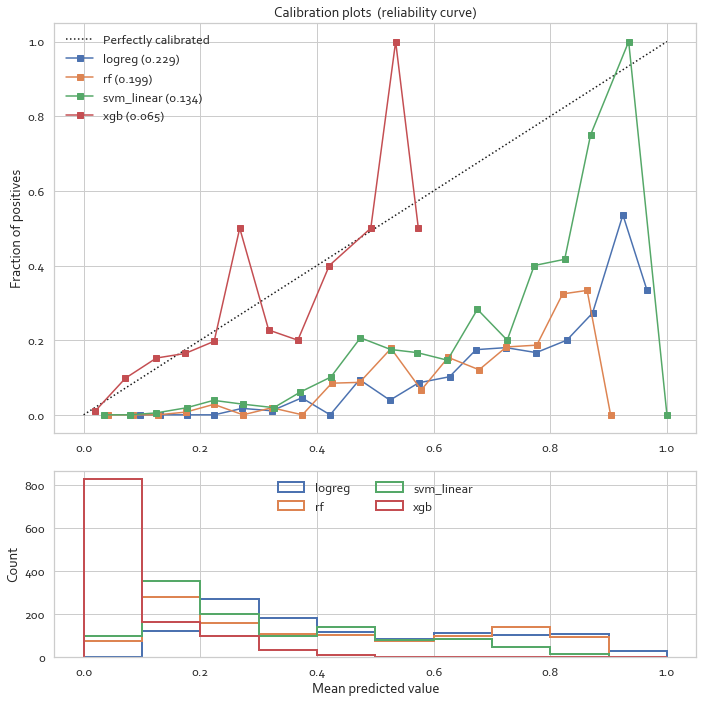

In [331]:
fig = plt.figure(2, figsize=(10, 10))
model_test_params_complete_case.reset_index(drop=True,inplace=True)

ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for model in cv_models.keys():
    
    if model !='xgb':
        y_pred = cv_models[model].predict(testX_complete_case)
        if hasattr(cv_models[model], "predict_proba"):
            prob_pos = cv_models[model].predict_proba(testX_complete_case)[:,1]
        else:  # use decision function
            prob_pos = cv_models[model].decision_function(testX_complete_case)
            prob_pos = \
                    (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

    else:
        y_pred = cv_models[model].predict(testX_complete_case.values)
        if hasattr(cv_models[model], "predict_proba"):
            prob_pos = cv_models[model].predict_proba(testX_complete_case.values)[:,1]
        else:  # use decision function
            prob_pos = cv_models[model].decision_function(testX_complete_case.values)
            prob_pos = \
                    (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min()) 
    

    clf_score = brier_score_loss(test_y_complete_case, prob_pos, pos_label=1)
    
    print("%s:" % model)
    print("\tBrier: %1.3f" % (clf_score))
    print("\tPrecision: %1.3f" % precision_score(test_y_complete_case, y_pred))
    print("\tRecall: %1.3f" % recall_score(test_y_complete_case, y_pred))
    print("\tF1: %1.3f\n" % f1_score(test_y_complete_case, y_pred))

    fraction_of_positives, mean_predicted_value = \
        calibration_curve(test_y_complete_case, prob_pos, n_bins=20)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s (%1.3f)" % (model, clf_score))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=model,
             histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="upper left")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

plt.show()

In [319]:
model

'xgb'

logreg:
	Brier: 0.229
	Precision: 0.183
	Recall: 0.871
	F1: 0.302

rf:
	Brier: 0.199
	Precision: 0.195
	Recall: 0.849
	F1: 0.317

svm_linear:
	Brier: 0.134
	Precision: 0.197
	Recall: 0.849
	F1: 0.319



ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46'] ['Referral', 'Readmission', 'Age_In_Months', 'Female', 'Weight', 'Length_Of_History', 'Number_Respiratory_Symptoms', 'Comorbidities', 'Temparature', 'Fever', 'Cough', 'Difficulty_Breathing', 'Cyanosis', 'Indrawing', 'Grunting', 'Acidotic_Breathing', 'Wheezing', 'Crackles', 'Respiratory_Rate', 'Tachypnea', 'Stridor', 'Pulse_Rate', 'Vomiting', 'Capillary_Refill', 'Capillary_Refill_Slow', 'Difficulty_Drinking', 'Thrush', 'Oedema', 'Stiff_Neck', 'Bulging_Fontanelle', 'Diarrhoea_Sign', 'WAZ', 'Convulsions', 'Age__1_11_months', 'Age__12_59_months', 'Age___1_month', 'Age___5_years', 'AVPU__Pain_response', 'AVPU__Unresponsive', 'AVPU__Verbal_response', 'Pallor__Mild_Moderate', 'Pallor__Severe', 'WAZ__Low', 'WAZ__Very_Low', 'Acute_Malnutrition__Moderate', 'Acute_Malnutrition__Severe', 'High_Malaria_Zone']
expected f13, f26, f32, f22, f23, f38, f11, f8, f19, f4, f1, f42, f2, f6, f20, f18, f28, f3, f15, f5, f40, f24, f9, f39, f12, f0, f7, f41, f37, f14, f44, f36, f27, f25, f30, f46, f10, f31, f33, f35, f21, f29, f43, f45, f17, f16, f34 in input data
training data did not have the following fields: AVPU__Pain_response, Cough, AVPU__Verbal_response, Acidotic_Breathing, WAZ__Very_Low, Oedema, High_Malaria_Zone, WAZ, Length_Of_History, Age___1_month, Crackles, Wheezing, Pulse_Rate, Weight, Comorbidities, Cyanosis, Readmission, Pallor__Mild_Moderate, Stridor, Tachypnea, Acute_Malnutrition__Moderate, Temparature, Capillary_Refill, Vomiting, Pallor__Severe, Difficulty_Breathing, Number_Respiratory_Symptoms, AVPU__Unresponsive, Difficulty_Drinking, Age_In_Months, Age__1_11_months, Capillary_Refill_Slow, Referral, Acute_Malnutrition__Severe, Female, Indrawing, Stiff_Neck, Age__12_59_months, Age___5_years, Respiratory_Rate, Grunting, Thrush, Convulsions, Bulging_Fontanelle, WAZ__Low, Fever, Diarrhoea_Sign

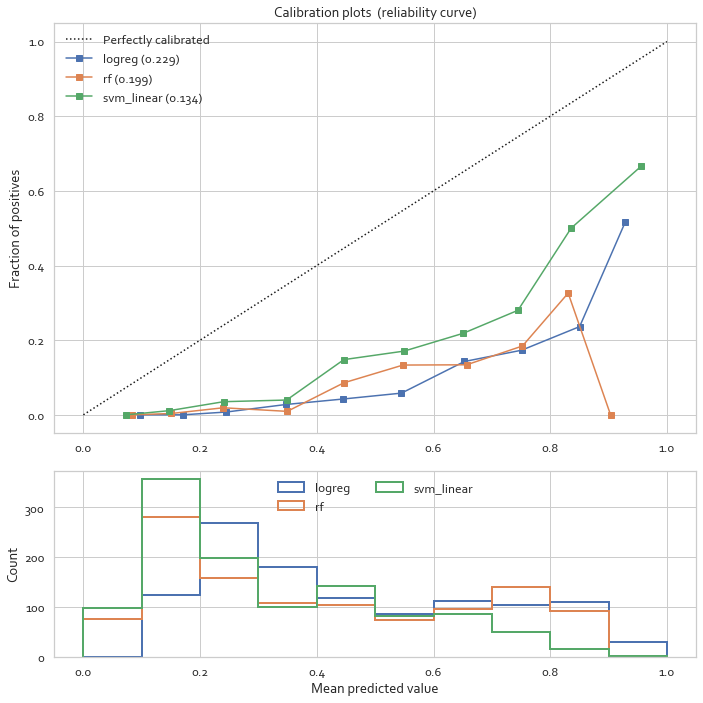

In [330]:
fig = plt.figure(2, figsize=(10, 10))
model_test_params_complete_case.reset_index(drop=True,inplace=True)

ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for model in cv_models.keys():
    
    y_pred = cv_models[model].predict(testX_complete_case)
    
    if hasattr(cv_models[model], "predict_proba"):
        prob_pos = cv_models[model].predict_proba(testX_complete_case)[:,1]
    else:  # use decision function
        prob_pos = cv_models[model].decision_function(testX_complete_case)
        prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

    clf_score = brier_score_loss(test_y_complete_case, prob_pos, pos_label=1)
    
    print("%s:" % model)
    print("\tBrier: %1.3f" % (clf_score))
    print("\tPrecision: %1.3f" % precision_score(test_y_complete_case, y_pred))
    print("\tRecall: %1.3f" % recall_score(test_y_complete_case, y_pred))
    print("\tF1: %1.3f\n" % f1_score(test_y_complete_case, y_pred))

    fraction_of_positives, mean_predicted_value = \
        calibration_curve(test_y_complete_case, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s (%1.3f)" % (model, clf_score))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=model,
             histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="upper left")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

plt.show()

### Variable importance

In [39]:
pipeline.set_params(**cv_grid.best_params_)
pipeline.fit(trainX,train_y)

names = []
importance_score = []
for name, importance in zip(features, pipeline.named_steps['xgbc'].feature_importances_):
    if importance > 0.0:
        names.append(name)
        importance_score.append(importance)
        
feature_importance = pd.DataFrame(list(zip(names,
                                  importance_score)),
                                  columns = ['Feature', 'Importance'])

NameError: name 'pipeline' is not defined

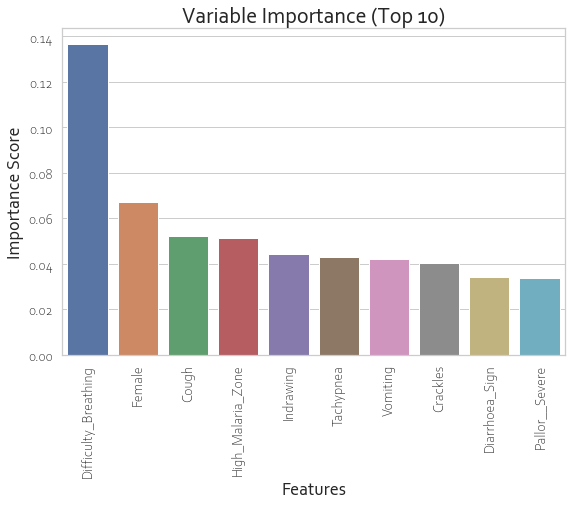

In [123]:
feature_importance = feature_importance.sort_values(by=['Importance'],ascending=False).head(10)

chart = sns.barplot(x='Feature', y='Importance', data=feature_importance)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90,
                  fontweight='light', fontsize='14')
plt.setp(chart.get_yticklabels(), rotation=0,
        fontweight='light', fontsize='14')
chart.axes.set_title("Variable Importance (Top 10)",fontsize=22)
chart.set_xlabel("Features",fontsize=18)
chart.set_ylabel("Importance Score",fontsize=18)

plt.show()